In [7]:
!pip install ezdxf
!pip install rectpack
!pip install shapely
!pip install matplotlib

In [8]:
import sys

!{sys.executable} -m pip install rectpack
!{sys.executable} -m pip install matplotlib
import matplotlib.pyplot as plt

In [9]:
import os
import cv2
import numpy as np
import sqlite3
import ezdxf
from shapely.geometry import Polygon
from rectpack import newPacker
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon

In [10]:
def process_image_to_dxf(image_path, dxf_output_path):
    """ Converts an image to a DXF file by detecting contours and filtering out noise. """

    # Read image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply thresholding to enhance contrast
    _, thresh = cv2.threshold(image, 180, 255, cv2.THRESH_BINARY)

    # Detect contours (including internal shapes)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Identify the main outer contour (largest area)
    max_area, main_contour_index = 0, -1
    for i, cnt in enumerate(contours):
        area = cv2.contourArea(cnt)
        if area > max_area:
            max_area = area
            main_contour_index = i  

    # Create DXF file
    doc = ezdxf.new()
    msp = doc.modelspace()
    shape_contours = []

    # Process all contours
    for i, cnt in enumerate(contours):
        epsilon = 0.005 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)

        if len(approx) >= 4 and cv2.contourArea(cnt) > 500:  # Ignore small fragments
            poly = Polygon([tuple(p[0]) for p in approx])

            if i == main_contour_index or hierarchy[0][i][3] == main_contour_index:
                shape_contours.append(poly)
                msp.add_lwpolyline(list(poly.exterior.coords), close=True)

    # Save DXF file
    doc.saveas(dxf_output_path)
    return shape_contours  # Returns detected contours (external & internal)

In [11]:
# Parameters
MIN_USABLE_AREA = 5000  # Minimum usable rectangle area
MIN_RECT_SIZE = 10      # Minimum rectangle side length (pixels)

def largestRectangleArea(heights):
    """Finds the largest rectangular area in a histogram."""
    stack = []
    max_area = left_index = right_index = max_height = 0

    for i, h in enumerate(list(heights) + [0]):
        while stack and h < heights[stack[-1]]:
            cur_h = heights[stack.pop()]
            cur_left = stack[-1] + 1 if stack else 0
            cur_width = i - cur_left
            area = cur_h * cur_width
            if area > max_area:
                max_area, left_index, right_index, max_height = area, cur_left, i - 1, cur_h
        stack.append(i)

    return max_area, left_index, right_index, max_height

def maximalRectangle(matrix):
    """Finds the largest axis-aligned rectangle in a binary matrix."""
    if matrix.size == 0:
        return 0, None

    n_rows, n_cols = matrix.shape
    heights = [0] * n_cols
    max_area, max_rect = 0, None

    for i in range(n_rows):
        for j in range(n_cols):
            heights[j] = heights[j] + 1 if matrix[i, j] == 1 else 0
        area, left, right, h = largestRectangleArea(heights)
        if area > max_area:
            max_area, max_rect = area, (i - h + 1, left, i, right)

    return max_area, max_rect

def load_dxf_and_find_max_rectangles(dxf_input_path, dxf_output_path):
    """Extracts the largest usable rectangles from a DXF file and saves results."""
    doc = ezdxf.readfile(dxf_input_path)
    msp = doc.modelspace()

    # Extract contours from LWPOLYLINE entities
    contours = [
        Polygon([(p[0], p[1]) for p in entity.get_points()])
        for entity in msp.query("LWPOLYLINE")
        if Polygon([(p[0], p[1]) for p in entity.get_points()]).is_valid
    ]
    
    if not contours:
        print("No valid contours found!")
        return

    contours.sort(key=lambda p: p.area, reverse=True)
    board_poly, hole_polys = contours[0], contours[1:]

    # Create binary mask
    x_min, y_min, x_max, y_max = board_poly.bounds
    board_width, board_height = int(np.ceil(x_max - x_min)), int(np.ceil(y_max - y_min))
    mask = np.zeros((board_height, board_width), dtype=np.uint8)

    board_points = np.array([[int(p[0] - x_min), int(p[1] - y_min)] for p in board_poly.exterior.coords], dtype=np.int32)
    cv2.fillPoly(mask, [board_points], 255)
    
    for hole in hole_polys:
        hole_points = np.array([[int(p[0] - x_min), int(p[1] - y_min)] for p in hole.exterior.coords], dtype=np.int32)
        cv2.fillPoly(mask, [hole_points], 0)

    binary_mask = (mask == 255).astype(np.uint8)
    rectangles = []

    while True:
        area, rect = maximalRectangle(binary_mask)
        if not rect:
            break

        width, height = rect[3] - rect[1] + 1, rect[2] - rect[0] + 1
        if area < MIN_USABLE_AREA or width < MIN_RECT_SIZE or height < MIN_RECT_SIZE:
            break

        global_rect = [
            (rect[1] + x_min, rect[0] + y_min),
            (rect[3] + 1 + x_min, rect[0] + y_min),
            (rect[3] + 1 + x_min, rect[2] + 1 + y_min),
            (rect[1] + x_min, rect[2] + 1 + y_min)
        ]
        rectangles.append((global_rect, area))

        binary_mask[rect[0]:rect[2]+1, rect[1]:rect[3]+1] = 0

    if not rectangles:
        print("No suitable rectangles found")
        return

    for rect_coords, area in rectangles:
        msp.add_lwpolyline(rect_coords, close=True)

    total_area = sum(a for _, a in rectangles)
    doc.saveas(dxf_output_path)
    print(f"DXF saved: {dxf_output_path}, Total Rectangles: {len(rectangles)}, Total Area: {total_area:.2f}px²")


In [12]:
def display_dxf(dxf_path):
    """Displays a DXF file using Matplotlib inside Jupyter Notebook."""
    
    # Load DXF document
    doc = ezdxf.readfile(dxf_path)
    msp = doc.modelspace()
    
    # Initialize figure
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Parse DXF polylines
    for entity in msp.query("LWPOLYLINE"):
        points = [(p[0], p[1]) for p in entity.get_points()]
        polygon = MplPolygon(points, closed=True, edgecolor="blue", fill=False, linewidth=1)
        ax.add_patch(polygon)

    # Adjust plot limits
    ax.autoscale()
    ax.set_aspect('equal')
    ax.set_title(f"DXF Preview: {dxf_path}")
    plt.axis("on")
    plt.show()

DXF saved: ./rec_output_dxf/IMG_1949.dxf, Total Rectangles: 3, Total Area: 51572.00px²


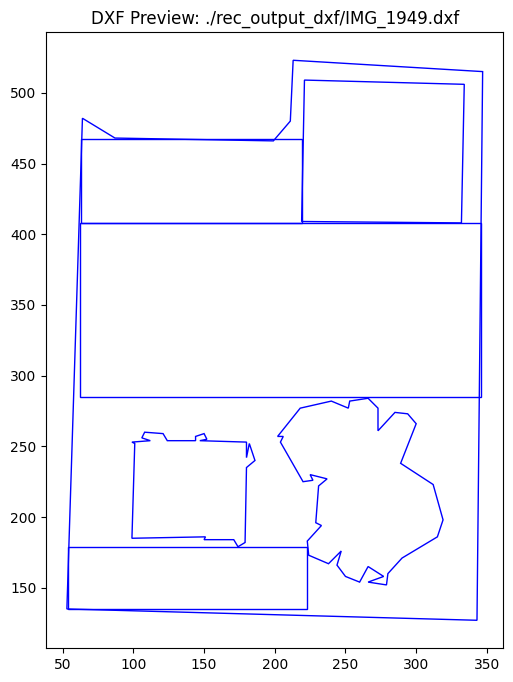

DXF saved: ./rec_output_dxf/IMG_1952.dxf, Total Rectangles: 2, Total Area: 40340.00px²


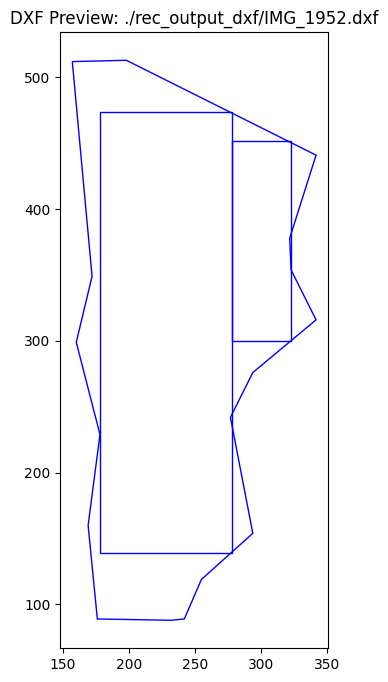

DXF saved: ./rec_output_dxf/IMG_1954.dxf, Total Rectangles: 2, Total Area: 23986.00px²


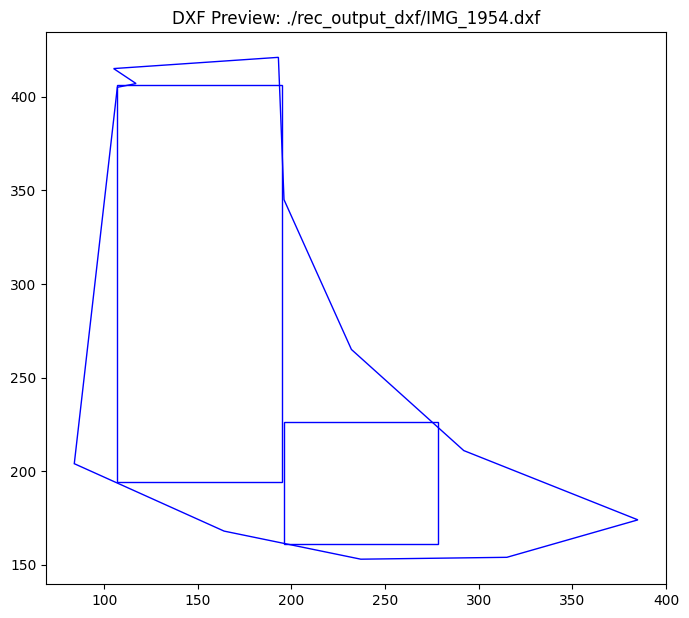

In [13]:
# Input and output directories
input_dir = "./input/"  # Set to the folder where images are stored
output_dir = "./output_dxf/"  # DXF output folder
rec_output_dir = "./rec_output_dxf/"
# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)
os.makedirs(rec_output_dir, exist_ok=True)
# Process all .webp images in the folder
for file_name in os.listdir(input_dir):
    if file_name.lower().endswith(".png"):
        image_path = os.path.join(input_dir, file_name)
        dxf_output_path = os.path.join(output_dir, f"{os.path.splitext(file_name)[0]}.dxf")
        rec_output_path = os.path.join(rec_output_dir, f"{os.path.splitext(file_name)[0]}.dxf")
        process_image_to_dxf(image_path, dxf_output_path)
        load_dxf_and_find_max_rectangles(dxf_output_path, rec_output_path)
        # Example Usage

        display_dxf(rec_output_path)